# DLC and Loads Comparisons between AWC Cases

In [2]:
#!/usr/bin/env python3
import os,sys
import numpy as np 
#import ruamel.yaml as yaml
import yaml
import argparse
import pathlib
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import fatpack


### Set parameters and load data

In [14]:
                
turbines = ['T0','T1_6D']
data_dir = '/ascldap/users/gyalla/GPFS/Advanced_Controls/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/'
cases = ['Baseline',\
    'WM_Helix_A2_St_0p3',\
    'WM_Helix_A4_St_0p3',\
    'WM_Pulse_A2_St_0p3',\
    'WM_Pulse_A4_St_0p3',\
    'WM_SideToSide_A2_St_0p3',\
    'WM_SideToSide_A4_St_0p3',\
    'WS_m10',\
    'WS_m20',\
    'WS_p10',\
    'WS_p20']

vars_and_labels = {'Time':('Time','s'),
            'RotSpeed':('Rotor Speed','rad / s'),
            'GenPwr':('Gen. Power','W'),
            'BldPitch1':('Blade Pitch','deg / s'),
            'RootMyb1':('Flapwise Moment','kN-m'), 
            'RootMxb1':('Edgewise Moment','kN-m'),
            'RotTorq':('Rotor Torque','kN-m'),
            'TwrBsMxt':('Tower base side-to-side moment','kN-m'),
            'TwrBsMyt':('Tower base Fore-aft Moment','kN-m'),
            'YawBrMyp':('Yaw Bearing Nodding Moment','kN-m'),
            'YawBrMzp':('Yaw Bearing Yawing Moment','kN-m'),
            'LSSTipMys':('LSS Nodding Moment','kN-m'),
            'LSSTipMzs':('LSS Yawing Moment','kN-m')}
vars = list(vars_and_labels.keys())

In [15]:
dataMean = {}
dataDEL  = {}
for caseiter, case in enumerate(cases):
    dataMean[case] = {}
    dataDEL[case] = {}
    for turbineiter, turbine in enumerate(turbines):
        file = data_dir + '/' + case + '/postpro/OpenFAST/' + turbine +'_mean.csv'
        dataMean[case][turbine] = pd.read_csv(file)

        file = data_dir + '/' + case + '/postpro/OpenFAST/' + turbine +'_DEL.csv'
        dataDEL[case][turbine] = pd.read_csv(file)



### Power vs DEL per turbine

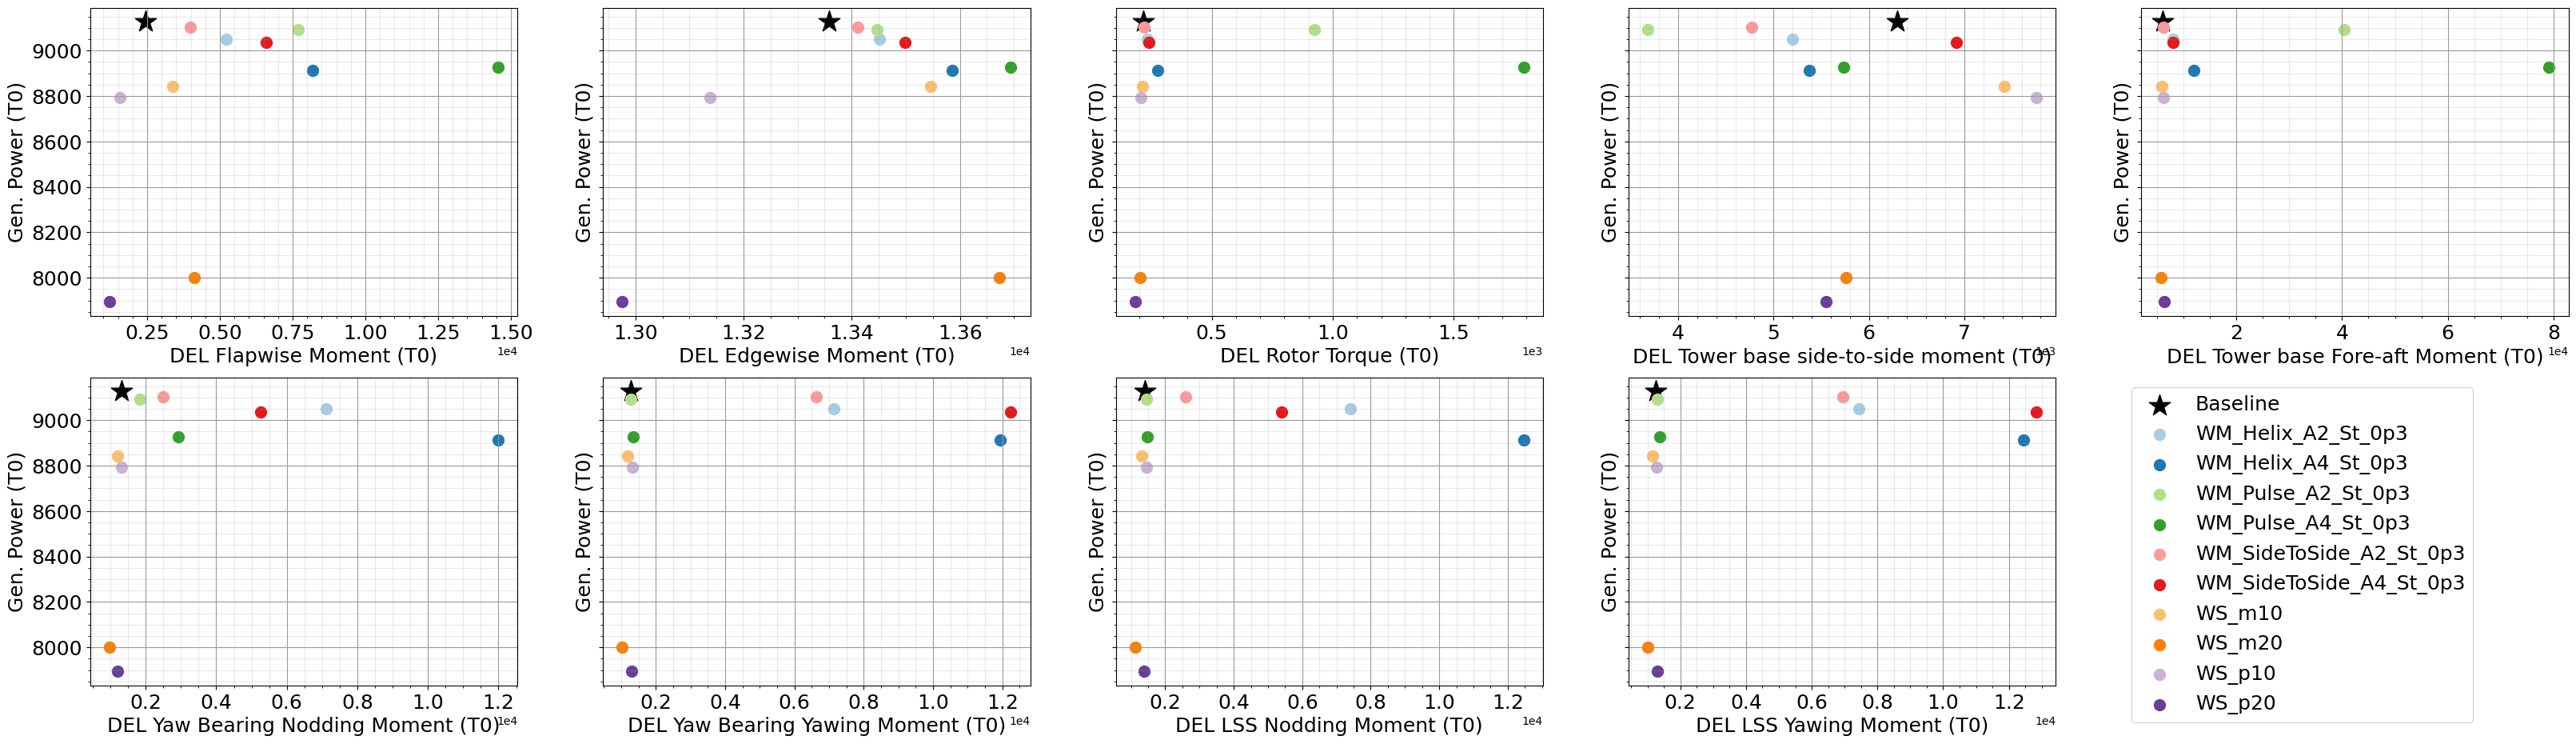

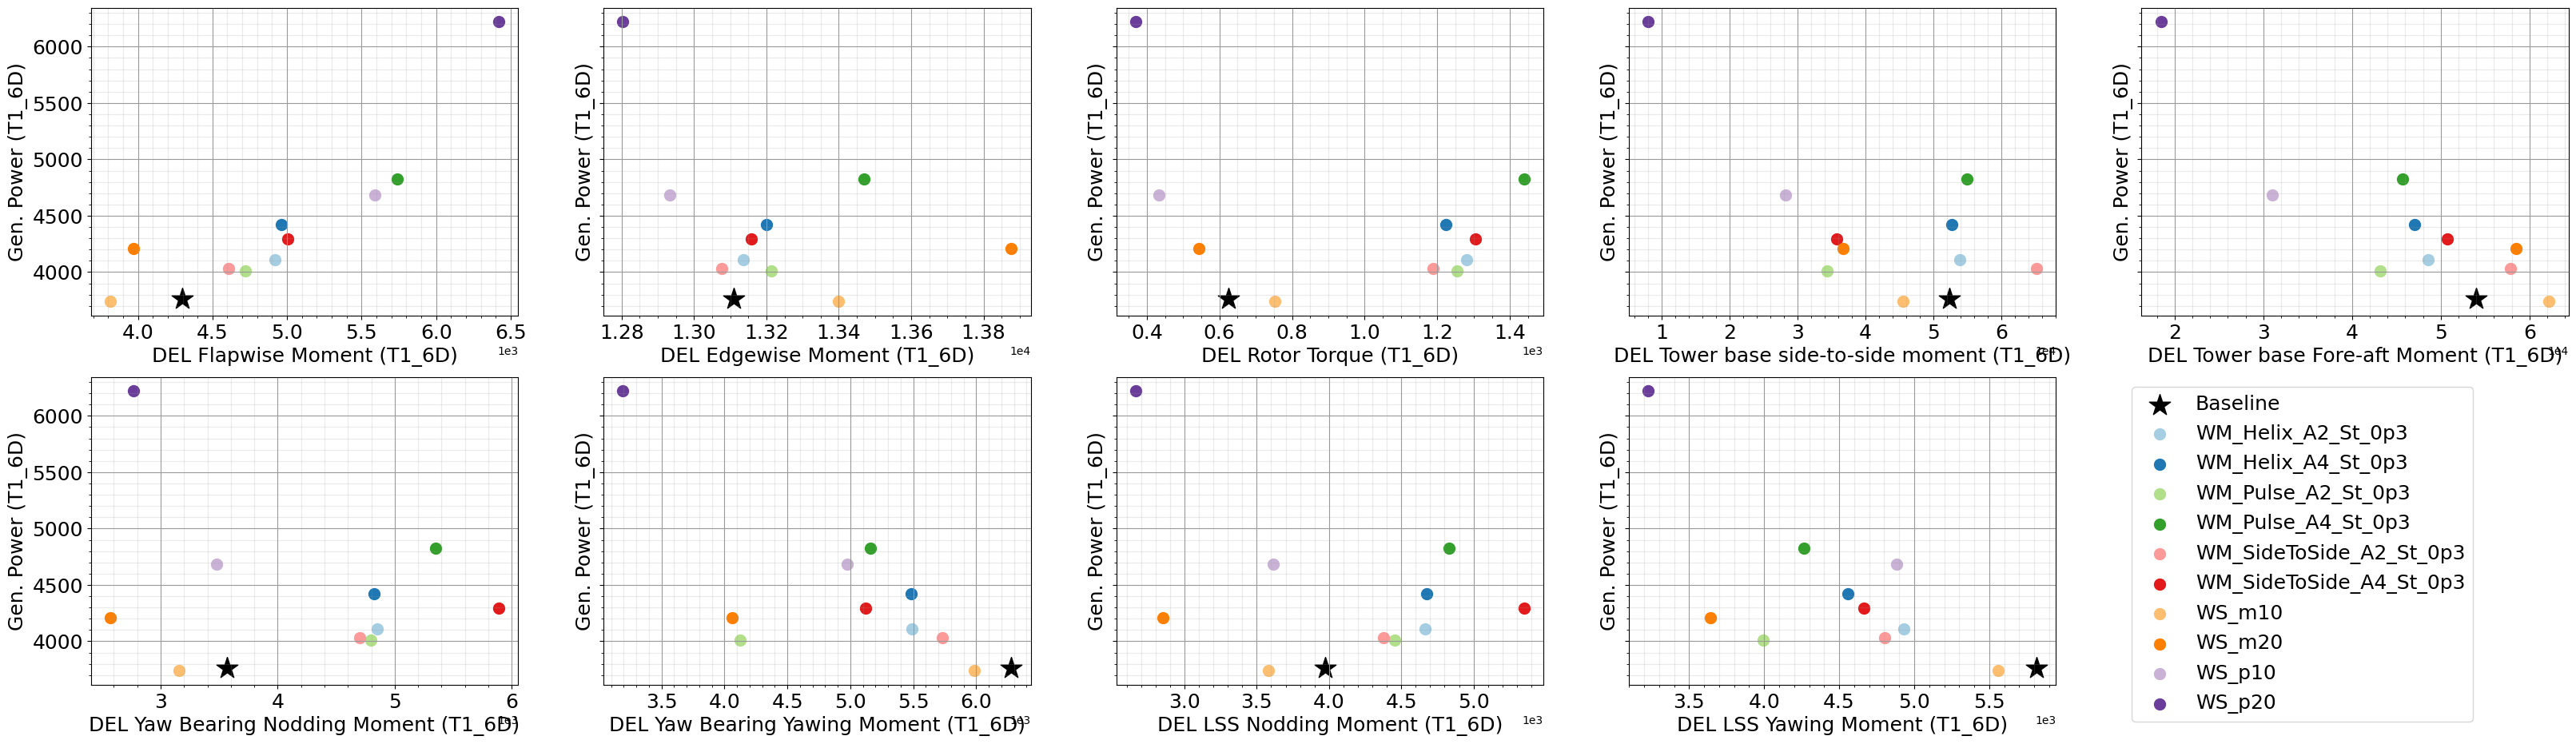

In [39]:
#colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
for turbine in turbines:
    colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    fig, ax1 = plt.subplots(2,5,figsize=(40,11),sharex=False,sharey=True)
    ax1=ax1.flatten()
    ax_counter = 0
    for quantity in vars[4:]:
        for counter ,case in enumerate(cases):
            if 'Baseline' in case:
                marker = '*'
            else:
                marker = '.'
            ax1[ax_counter].scatter(dataDEL[case][turbine][quantity],dataMean[case][turbine]['GenPwr'],label=case,c=colors[counter],marker=marker,s=400)
            counter += 1

        fsize = 18
        #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
        ax1[ax_counter].set_ylabel("Gen. Power (" + turbine + ")",fontsize=fsize)
        ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (" + turbine +")",fontsize=fsize)
        ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
        ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax1[ax_counter].minorticks_on()
        ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
        ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
        ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

        #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
        #fig.tight_layout()
        ax_counter += 1

    ax1[-1].axis('off')
    ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)

### Combined Power vs DEL

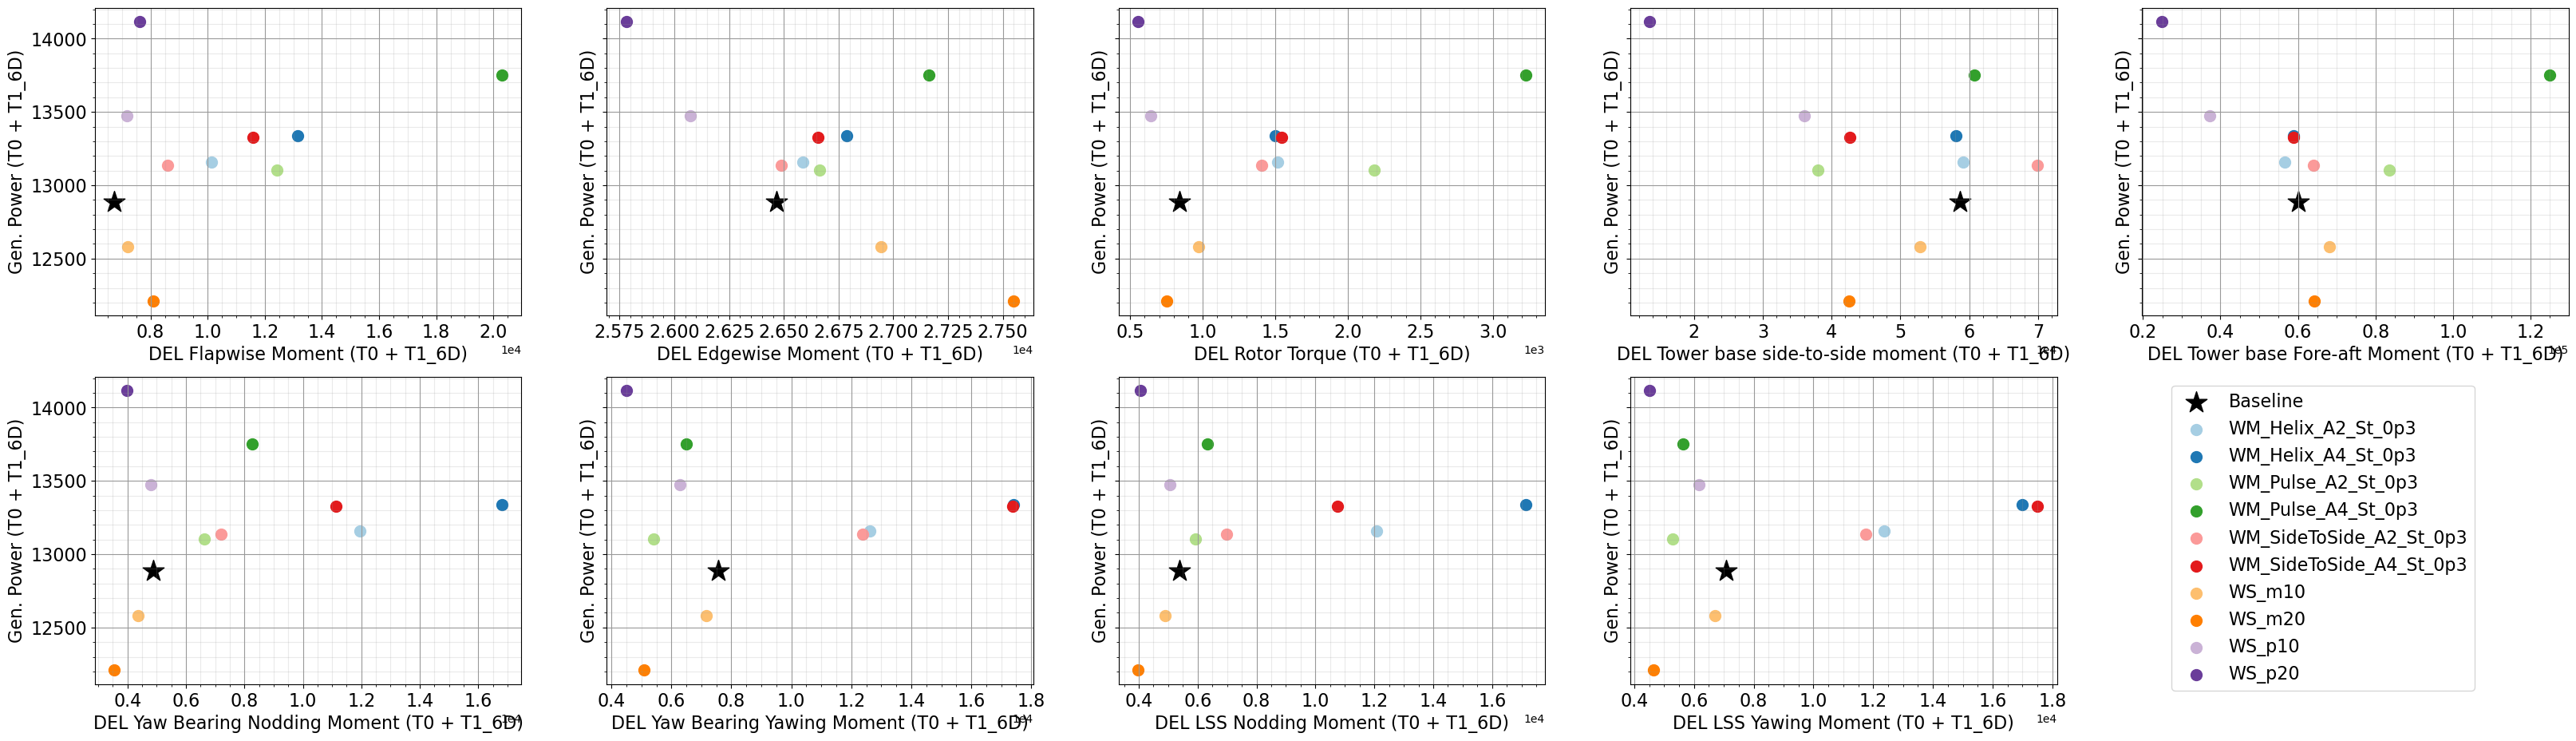

In [38]:
#colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,11),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0
for quantity in vars[4:]:
    for counter ,case in enumerate(cases):
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        combined_DEL = dataDEL[case][turbines[0]][quantity] + dataDEL[case][turbines[1]][quantity]
        combined_PWR = dataMean[case][turbines[0]]['GenPwr']+dataMean[case][turbines[1]]['GenPwr']
        ax1[ax_counter].scatter(combined_DEL,combined_PWR,label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 16
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Gen. Power (" + turbines[0] + " + " + turbines[1] + ")",fontsize=fsize)
    ax1[ax_counter].set_xlabel("DEL " + vars_and_labels[quantity][0] + " (" + turbines[0] + " + " + turbines[1] + ")",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)

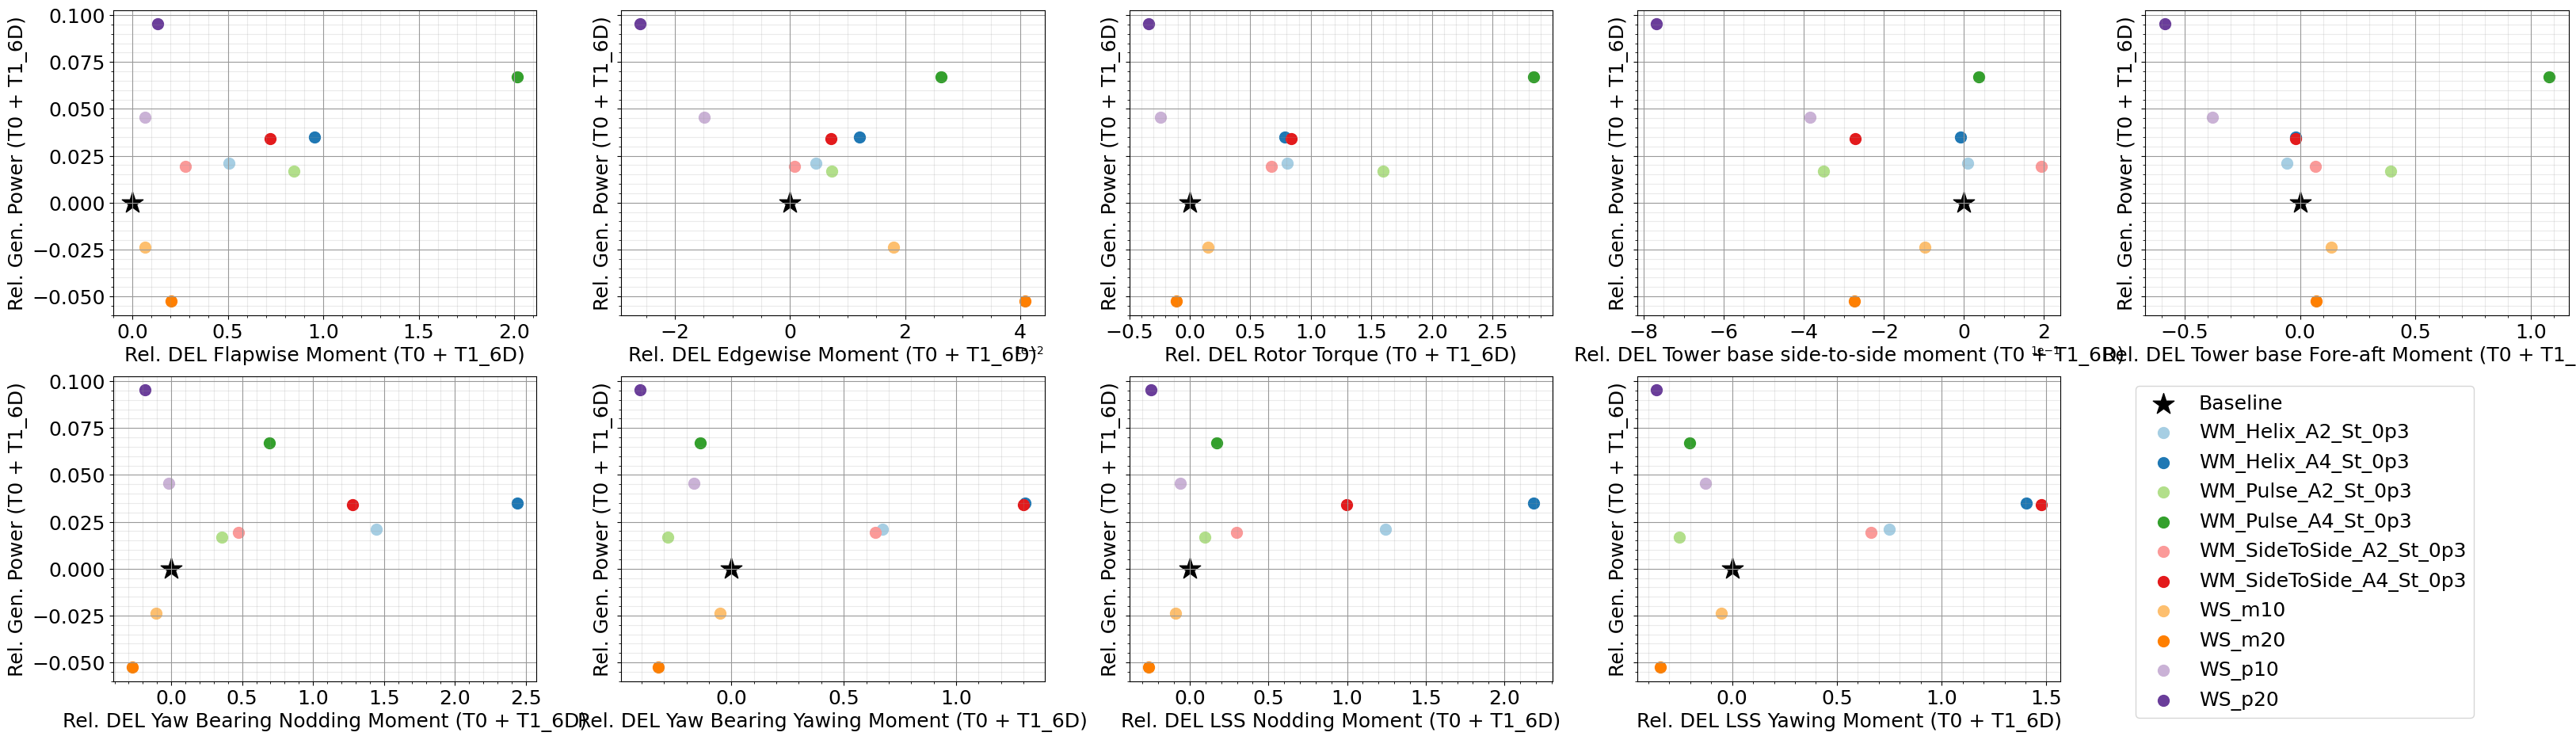

In [40]:
#colors = ['k','tab:blue','tab:red','tab:purple','tab:green']
colors = ['k','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
fig, ax1 = plt.subplots(2,5,figsize=(40,11),sharex=False,sharey=True)
ax1=ax1.flatten()
ax_counter = 0
for quantity in vars[4:]:
    for counter ,case in enumerate(cases):
        if 'Baseline' in case:
            marker = '*'
        else:
            marker = '.'
        baseline_PWR = dataMean['Baseline'][turbines[0]]['GenPwr']+dataMean['Baseline'][turbines[1]]['GenPwr']
        baseline_DEL= dataDEL['Baseline'][turbines[0]][quantity] + dataDEL['Baseline'][turbines[1]][quantity]

        combined_DEL = dataDEL[case][turbines[0]][quantity] + dataDEL[case][turbines[1]][quantity]
        combined_PWR = dataMean[case][turbines[0]]['GenPwr']+dataMean[case][turbines[1]]['GenPwr']

        combined_DEL = (combined_DEL-baseline_DEL)/baseline_DEL
        combined_PWR = (combined_PWR-baseline_PWR)/baseline_PWR
        ax1[ax_counter].scatter(combined_DEL,combined_PWR,label=case,c=colors[counter],marker=marker,s=400)
        counter += 1

    fsize = 18
    #ax1[ax_counter].set_xlabel("DEL " + quantity,fontsize=fsize) 
    ax1[ax_counter].set_ylabel("Rel. Gen. Power (" + turbines[0] + " + " + turbines[1] + ")",fontsize=fsize)
    ax1[ax_counter].set_xlabel("Rel. DEL " + vars_and_labels[quantity][0] + " (" + turbines[0] + " + " + turbines[1] + ")",fontsize=fsize)
    ax1[ax_counter].grid(visible=True, which='major', color='#999999', linestyle='-')
    ax1[ax_counter].grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax1[ax_counter].minorticks_on()
    ax1[ax_counter].tick_params(axis='x',labelsize=fsize)
    ax1[ax_counter].tick_params(axis='y',labelsize=fsize)
    ax1[ax_counter].ticklabel_format(style='sci',axis='x',scilimits=(0,0))

    #fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
    #fig.tight_layout()
    ax_counter += 1

ax1[-1].axis('off')
ax1[-2].legend(loc='upper right',bbox_to_anchor=(2,1),fontsize=fsize)